In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import InputLayer, Dense
from keras.layers import LSTM

In [ ]:
# 하이퍼파라미터

MY_PAST = 12 # 과거 시점의 길이. 12개의 이전 시점의 데이터를 사용하여 예측
MY_SPLIT = 0.8 # 훈련 및 테스트 세트로 분할하는 비율
MY_UNIT = 300 # LSTM 모델의 유닛(또는 뉴런)수
MY_SHAPE = (MY_PAST, 1) # (12개의 시점, 각 시점마다 1개의 특성)

MY_EPOCH = 300 # 훈련 과정에서 사용할 에포크(전체 데이터 세트를 한 번 훈련하는 데 필요한 반복 횟수)
MY_BATCH = 64 # 각 훈련 단계에서 사용할 배치 크기
np.set_printoptions(precision=3) # Numpy에서 출력하는 실수의 소수점 자릿수 설정

In [ ]:
# 데이터 준비
# 두 번째 열에 해당하는 데이터를 읽어와서 데이터프레임으로 저장

raw = pd.read_csv('./airline.csv', header=None, usecols=[1])

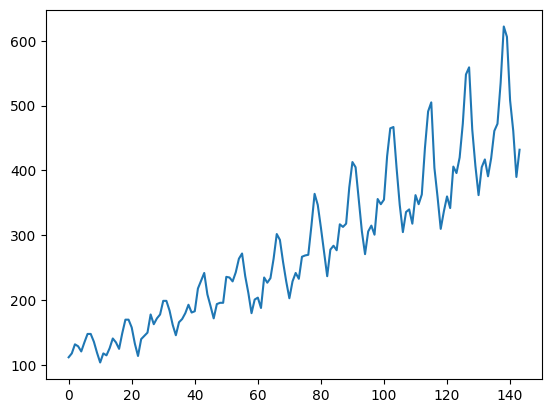

In [ ]:
# 시계열 데이터 시각화
plt.plot(raw)
plt.show()

In [ ]:
# 데이터 원본 출력
print('원본 데이터 샘플 13개')
print(raw.head(13))

print('\n원본 데이터 통계')
print(raw.describe())

원본 데이터 샘플 13개
      1
0   112
1   118
2   132
3   129
4   121
5   135
6   148
7   148
8   136
9   119
10  104
11  118
12  115

원본 데이터 통계
                1
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


In [ ]:
# MinMax 데이터 정규화
scaler = MinMaxScaler() # 데이터의 값을 [0, 1]범위로 변환하여 스케일을 조정
s_data = scaler.fit_transform(raw)

print('\nMinMax 정규화 형식:', type(s_data)) # 정규화된 데이터의 유형 확인


MinMax 정규화 형식: <class 'numpy.ndarray'>


In [ ]:
# 정규화 데이터 출력
df = pd.DataFrame(s_data)

print('\n정규화 데이터 샘플 13개')
print(df.head(13))

print('\n정규화 데이터 통계')
print(df.describe())


정규화 데이터 샘플 13개
           0
0   0.015444
1   0.027027
2   0.054054
3   0.048263
4   0.032819
5   0.059846
6   0.084942
7   0.084942
8   0.061776
9   0.028958
10  0.000000
11  0.027027
12  0.021236

정규화 데이터 통계
                0
count  144.000000
mean     0.340345
std      0.231595
min      0.000000
25%      0.146718
50%      0.311776
75%      0.495174
max      1.000000


In [ ]:
# 13개 묶음으로 데이터 분할, 시계열 데이터로 변환

bundle = [] # 변환된 시계열 데이터를 저장할 빈 리스트 생성
for i in range(len(s_data) - MY_PAST): # 데이터 길이에서 'MY_PAST'를 뺀 범위에서 반복문 실행
    bundle.append(s_data[i: i+MY_PAST+1])

In [ ]:
# 데이터 분할 결과 확인
print('\n총 13개 묶음의 수:', len(bundle))
print(bundle[0])
print(bundle[1])


총 13개 묶음의 수: 132
[[0.015]
 [0.027]
 [0.054]
 [0.048]
 [0.033]
 [0.06 ]
 [0.085]
 [0.085]
 [0.062]
 [0.029]
 [0.   ]
 [0.027]
 [0.021]]
[[0.027]
 [0.054]
 [0.048]
 [0.033]
 [0.06 ]
 [0.085]
 [0.085]
 [0.062]
 [0.029]
 [0.   ]
 [0.027]
 [0.021]
 [0.042]]


In [ ]:
# Numpy로 전환
print('분할 데이터의 타입:', type(bundle))
bundle = np.array(bundle)
print('분할 데이터의 모양:', bundle.shape)

분할 데이터의 타입: <class 'list'>
분할 데이터의 모양: (132, 13, 1)


In [ ]:
# 시계열 데이터를 입력(X_data)과 출력(Y_data)으로 분할
X_data = bundle[:, 0:MY_PAST] # 각 데이터 포인터에서 과거 데이터만 추출
Y_data = bundle[:, -1] # 현재 데이터만 추출

In [ ]:
# 시계열 데이터를 학습용과 평가용으로 분할
split = int(len(bundle) * MY_SPLIT) # int() 함수를 사용하여 계산된 값의 소수점 이하를 버리고 정수로 변환
X_train = X_data[: split]
X_test = X_data[split:]

Y_train = Y_data[: split]
Y_test = Y_data[split:]

In [ ]:
# 최종 데이터 모양
print('\n학습용 입력 데이터 모양:', X_train.shape)
print('학습용 출력 데이터 모양:', Y_train.shape)

print('평가용 입력 데이터 모양:', X_test.shape)
print('평가용 출력 데이터 모양:', Y_test.shape)


학습용 입력 데이터 모양: (105, 12, 1)
학습용 출력 데이터 모양: (105, 1)
평가용 입력 데이터 모양: (27, 12, 1)
평가용 출력 데이터 모양: (27, 1)


In [ ]:
##### 인공 신경망 구현 #####

# 시계열 데이터를 처리하기 위한 RNN(Recurrent Neural Network) 모델 구현
# 케라스 RNN은 2차원 입력만 허용

model = Sequential() # 케라스에서 모델을 생성할 때 사용되는 함수로, 순차적인 레이어를 쌓아 모델을 정의
model.add(InputLayer(input_shape=MY_SHAPE)) # 입력 데이터의 모양을 정의하는 입력 레이어 추가
model.add(LSTM(MY_UNIT)) # LSTM 레이어 추가

model.add(Dense(1, activation='sigmoid')) # 하나의 뉴런을 가진 출력 레이어이며, 활성화 함수로 시그모이드 함수 사용

print('\nRNN 요약')
model.summary()

# LSTM 레이어의 파라미터 수가 많은 이유? LSTM의 내부 구조가 복잡하고 많은 가중치(weight)와 편향(bias)을 가지기 때문


RNN 요약
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300)               362400    
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 362701 (1.38 MB)
Trainable params: 362701 (1.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
##### 인공 신경망 학습 #####

# 'compile' 메소드를 사용하여 최적화 함수(optimizer)와 손실 함수(loss function) 지정

# rmsprop: RMSprop 옵티마이저, mse: 평균 제곱 오차(Mean Squared Error) 손실 함수
model.compile(optimizer='rmsprop', loss='mse')

begin = time()
print('\nRNN 학습 시작')

model.fit(X_train,
          Y_train,
          epochs=MY_EPOCH, # 전체 데이터셋을 반복하는 횟수
          batch_size=MY_BATCH, # 한 번의 반복에 사용되는 데이터 샘플의 개수
          verbose=0) # 학습 진행 상황을 출력하지 않도록 설정

end = time()
print('총 학습 시간: {:.1f}초'.format(end - begin)) # end-begin을 통해 학습에 소요된 시간을 측정


RNN 학습 시작
총 학습 시간: 48.0초


In [ ]:
##### 인공 신경망 평가 #####

# RNN 평가
loss = model.evaluate(X_test,
                      Y_test,
                      verbose=0)

print('최종 MSE 손실값: {:.3f}'.format(loss))

최종 MSE 손실값: 0.014


In [ ]:
# RNN 추측
pred = model.predict(X_test)
pred = scaler.inverse_transform(pred)
pred = pred.flatten().astype(int)
print('\n추측 결과 원본:', pred)

1/1 [==============================] - 1s 522ms/step

추측 결과 원본: [402 397 402 406 412 423 431 441 451 452 447 431 423 420 428 436 444 454
 459 468 475 479 476 466 459 457 460]


In [ ]:
# 정답 역전환
truth = scaler.inverse_transform(Y_test)
truth = truth.flatten().astype(int)
print('\n정답 원본:', truth)


정답 원본: [359 310 337 360 342 406 396 420 472 548 559 463 407 362 405 417 391 419
 461 472 535 622 606 508 461 390 432]


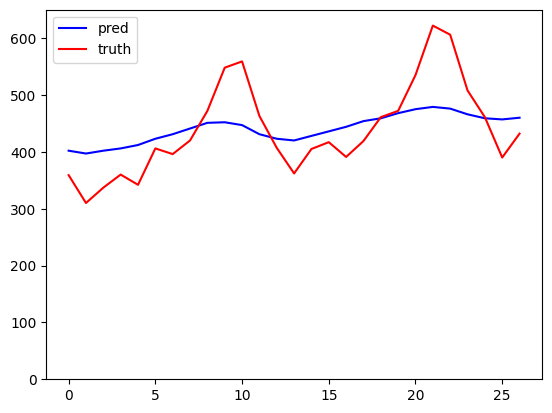

In [ ]:
# line plot 구성
axes = plt.gca()
axes.set_ylim([0, 650])

sns.lineplot(data=pred, label='pred', color='blue')
sns.lineplot(data=truth, label='truth', color='red')

plt.show()